In [211]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
pd.pandas.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [7]:
dataPath = "m5-forecasting-accuracy/"
timesteps = 28

# EDA

In [166]:
calendar_df = pd.read_csv(dataPath + '/calendar.csv')
submission_file = pd.read_csv(dataPath + '/sample_submission.csv')
sell_prices = pd.read_csv(dataPath + '/sell_prices.csv')

In [76]:
train_sales = pd.read_csv(dataPath + '/sales_train_evaluation.csv')
validation = pd.read_csv(dataPath + '/sales_train_validation.csv')

### Basic Data Information

In [77]:
train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [78]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(6), datetime64[ns](1), int16(2), int8(5)
memory usage: 144.0 KB


In [79]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float16 
dtypes: category(2), float16(1), int16(1)
memory usage: 45.8 MB


### 0 distribution

In [55]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]

ids = np.random.choice(train_sales['id'].unique().tolist(), 1000)

series_ids = widgets.Dropdown(
    options=ids,
    value=ids[0],
    description='series_ids:'
)

def plot_data(series_ids):
    df = train_sales.loc[train_sales['id'] == series_ids][time_series_columns]
    df = pd.Series(df.values.flatten())

    df.plot(figsize=(20, 10), lw=2, marker='o')
    df.rolling(7).mean().plot(figsize=(20, 10), lw=2, marker='o', color='black')
    plt.axhline(df.mean(), lw=3, color='green')
    plt.grid()

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


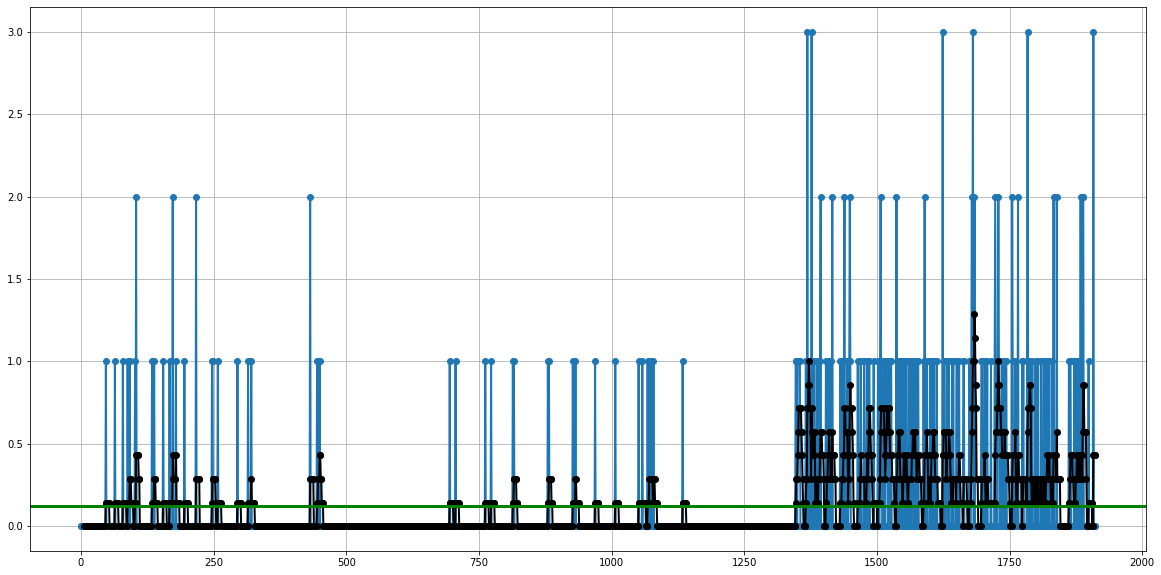

In [56]:
w = interactive(
    plot_data,
    series_ids=series_ids
)
display(w)

<AxesSubplot:>

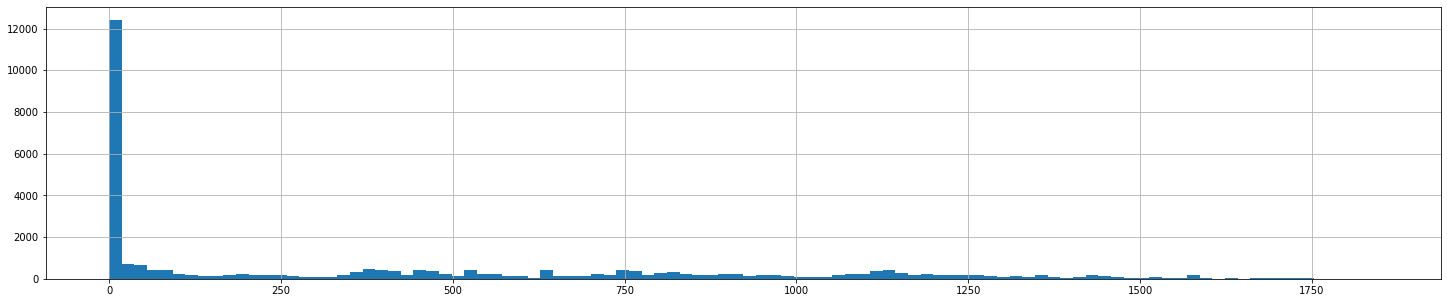

In [57]:
series_data = train_sales[time_series_columns].values
pd.Series((series_data != 0).argmax(axis=1)).hist(figsize=(25, 5), bins=100)

<AxesSubplot:>

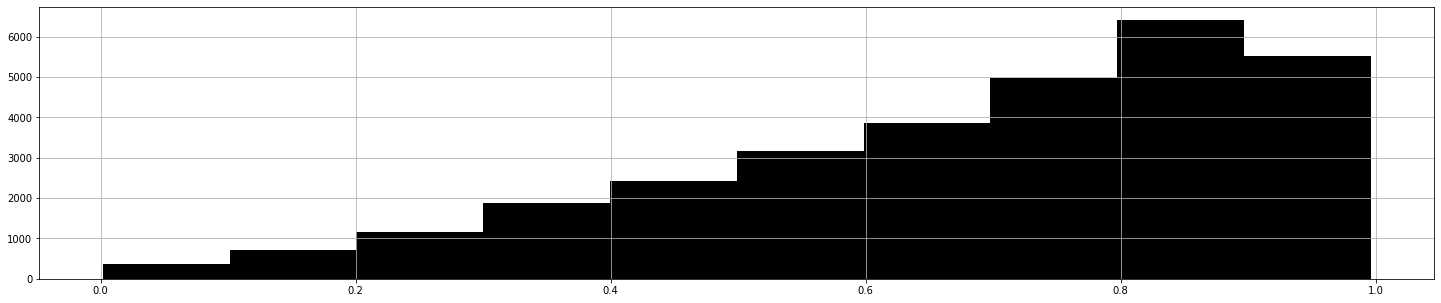

In [59]:
pd.Series((series_data == 0).sum(axis=1) / series_data.shape[1]).hist(figsize=(25, 5), color='black')

In [62]:
train_sales.isnull().sum().sort_values(ascending = False)

d_1941    0
d_663     0
d_635     0
d_636     0
d_637     0
         ..
d_1297    0
d_1298    0
d_1299    0
d_1300    0
id        0
Length: 1947, dtype: int64

### Memory Reduction¶

In [80]:
# memory usage reduction
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [81]:
train_sales = downcast(train_sales)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar_df)

In [82]:
# date variables list
d_cols = [c for c in train_sales.columns if 'd_' in c]

In [83]:
top5 = train_sales.set_index("id")[d_cols].sum(1).sort_values(ascending  = False)[:5].index

### Data Melt

In [84]:
grid_df = pd.melt(train_sales, 
                  id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                  var_name = 'd', 
                  value_name = "sales")

In [85]:
grid_df.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


### Combine melted dataset and the calendar dataset

In [90]:
master = pd.merge(grid_df,calendar, on = "d")
master.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [88]:
# from itertools import cycle, islice
# def decompose(y):
#     rcParams['figure.figsize'] = 18, 8
#     decomposition = sm.tsa.seasonal_decompose(y, model='additive')
#     fig = decomposition.plot()
#     plt.show()

### 1. State

In [87]:
def sales(feat,param):
    sales_df = master.loc[master[feat] == param]
    sales_df['date'] = pd.to_datetime(sales_df['date'])
    sales_df =sales_df.groupby('date')['sales'].sum().reset_index()
    sales_df = sales_df.set_index('date')
    return sales_df

In [91]:
master.state_id.unique()

['CA', 'TX', 'WI']
Categories (3, object): ['CA', 'TX', 'WI']

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



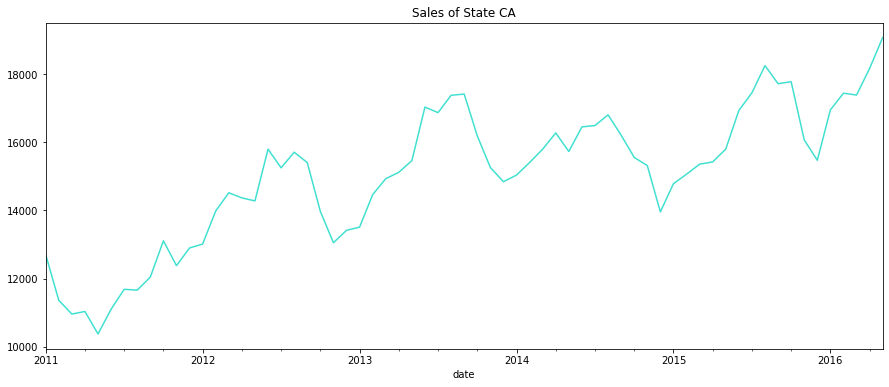

In [96]:
CA = sales("state_id","CA") # create a dataframe for the state CA
y_ca = CA['sales'].resample('MS').mean() # taking monthly average
y_ca.plot(figsize=(15, 6),color = 'turquoise',title = ("Sales of State CA"))
plt.ylabel = ("Sales")
plt.show()

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



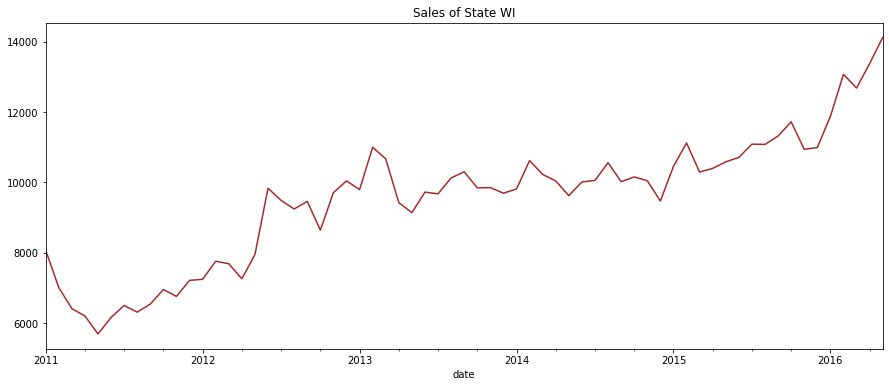

In [95]:
WI = sales("state_id","WI")
y_wi = WI['sales'].resample('MS').mean()
y_wi.plot(figsize=(15, 6),color = 'brown',title = ("Sales of State WI"))
plt.ylabel = ("Sales")
plt.show()

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



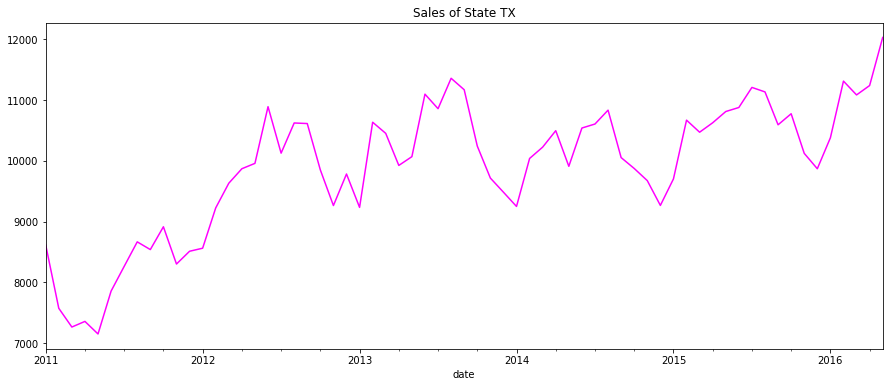

In [97]:
TX = sales("state_id","TX")
y_tx = TX['sales'].resample('MS').mean()
y_tx.plot(figsize=(15, 6),color = 'magenta',title = ("Sales of State TX"))
plt.show()

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

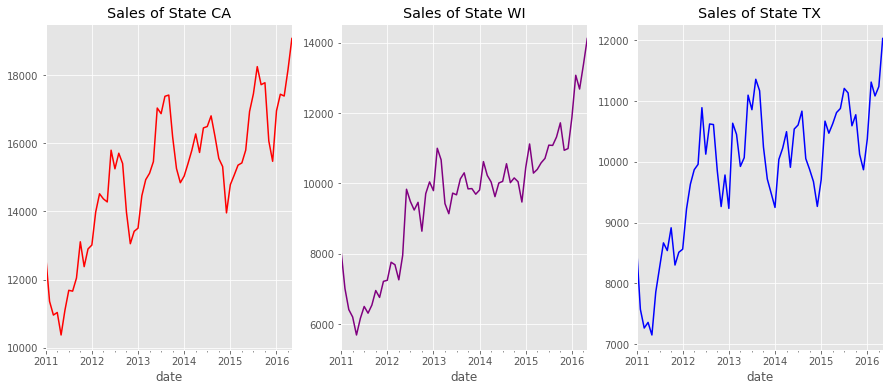

In [110]:
plt.subplot(1,3,1) # 一行三列,这是第一个图plt.subplot('行','列','编号')
CA = sales("state_id","CA") # create a dataframe for the state CA
y_ca = CA['sales'].resample('MS').mean() # taking monthly average
y_ca.plot(figsize=(15, 6),color = 'red',title = ("Sales of State CA"))
plt.ylabel = ("Sales")

plt.subplot(1,3,2) # 一行三列,这是第二个图
WI = sales("state_id","WI")
y_wi = WI['sales'].resample('MS').mean()
y_wi.plot(figsize=(15, 6),color = 'purple',title = ("Sales of State WI"))
plt.ylabel = ("Sales")

plt.subplot(1,3,3) # 一行三列,这是第三个图
TX = sales("state_id","TX")
y_tx = TX['sales'].resample('MS').mean()
y_tx.plot(figsize=(15, 6),color = 'blue',title = ("Sales of State TX"))



plt.show()

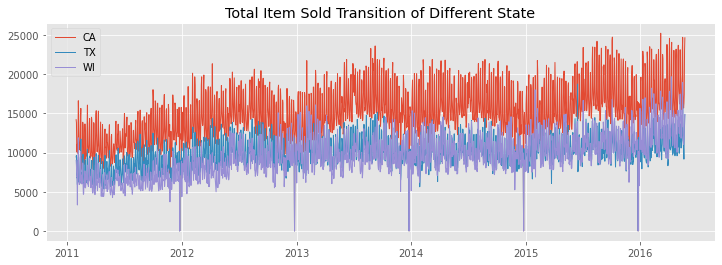

In [109]:
state_series = master.groupby(["state_id", "date"])["sales"].sum()
plt.figure(figsize=(12, 4))
plt.plot(state_series[state_series.index.get_level_values("state_id") == "CA"].index.get_level_values("date"), state_series[state_series.index.get_level_values("state_id") == "CA"].values, label="CA",linewidth=1)
plt.plot(state_series[state_series.index.get_level_values("state_id") == "TX"].index.get_level_values("date"), state_series[state_series.index.get_level_values("state_id") == "TX"].values, label="TX",linewidth=1)
plt.plot(state_series[state_series.index.get_level_values("state_id") == "WI"].index.get_level_values("date"), state_series[state_series.index.get_level_values("state_id") == "WI"].values, label="WI",linewidth=1)
plt.xlabel= ("Year")
plt.ylabel = ("Sales")
plt.title("Total Item Sold Transition of Different State")
plt.legend()

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



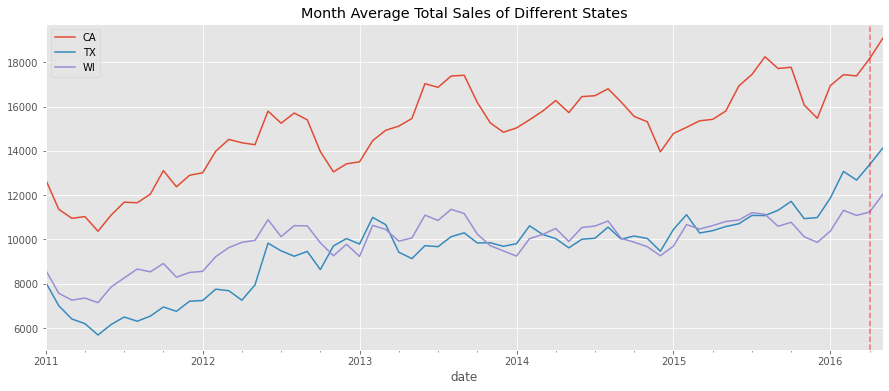

In [118]:
state_list = master.state_id.unique() #all states id

CA = sales("state_id","CA") # create a dataframe for the state CA
monA_CA = CA['sales'].resample('MS').mean() # taking monthly average
WI = sales("state_id","WI")
monA_WI = WI['sales'].resample('MS').mean()
TX = sales("state_id","TX")
monA_TX = TX['sales'].resample('MS').mean()
monA_CA.plot(figsize=(15, 6))
monA_WI.plot(figsize=(15, 6))
monA_TX.plot(figsize=(15, 6),title = ("Month Average Total Sales of Different States"))
plt.legend(state_list)
plt.ylabel = ("Sales")
plt.axvline(x=dt.datetime(2016,4,24), color='red', linestyle="dashed", alpha=0.5)
plt.show()

### 2. Category

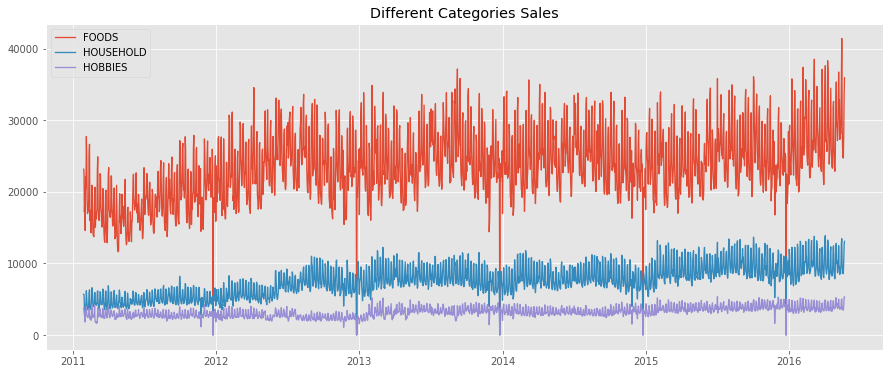

In [122]:
cat_series = master.groupby(["cat_id", "date"])["sales"].sum()
plt.figure(figsize=(15, 6))
plt.plot(cat_series[cat_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), cat_series[cat_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS",linewidth=1.3)
plt.plot(cat_series[cat_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), cat_series[cat_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD",linewidth=1.3)
plt.plot(cat_series[cat_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), cat_series[cat_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES",linewidth=1.3)
plt.xlabel = ("Year")
plt.ylabel = ("Sales")
plt.title("Different Categories Sales")
plt.legend()

Text(0.5, 1.0, 'Total Sales  of Different Day in a Week ')

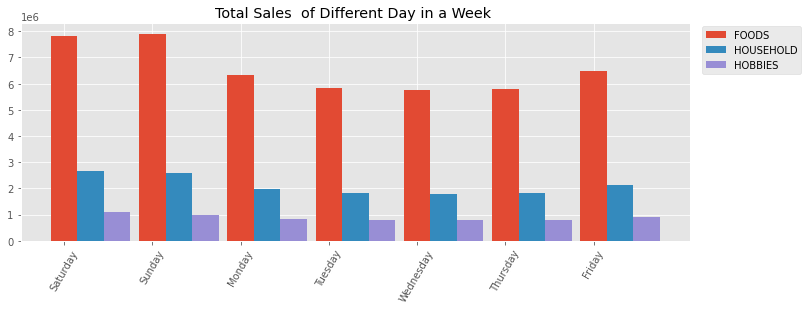

In [120]:
cat_wday = master.groupby(["cat_id", "wday"])["sales"].sum()

plt.figure(figsize=(12, 4))
left = np.arange(1,8) 
width = 0.3
weeklabel = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]    # Please Confirm df

plt.bar(left, cat_wday[cat_wday.index.get_level_values("cat_id") == "FOODS"].values, width=width, label="FOODS")
plt.bar(left + width, cat_wday[cat_wday.index.get_level_values("cat_id") == "HOUSEHOLD"].values, width=width, label="HOUSEHOLD")
plt.bar(left + width + width, cat_wday[cat_wday.index.get_level_values("cat_id") == "HOBBIES"].values, width=width, label="HOBBIES")
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.xticks(left, weeklabel, rotation=60)
plt.xlabel = ("day of week")
plt.ylabel = ("sales")
plt.title("Total Sales  of Different Day in a Week ")

### 3. Store

In [123]:
store_list = master.store_id.unique()
store_list_ca = [s for s in store_list if 'CA' in s]
store_list_tx = [s for s in store_list if 'TX' in s]
store_list_wi = [s for s in store_list if 'WI' in s]
store_list

['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
Categories (10, object): ['CA_1', 'CA_2', 'CA_3', 'CA_4', ..., 'TX_3', 'WI_1', 'WI_2', 'WI_3']

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



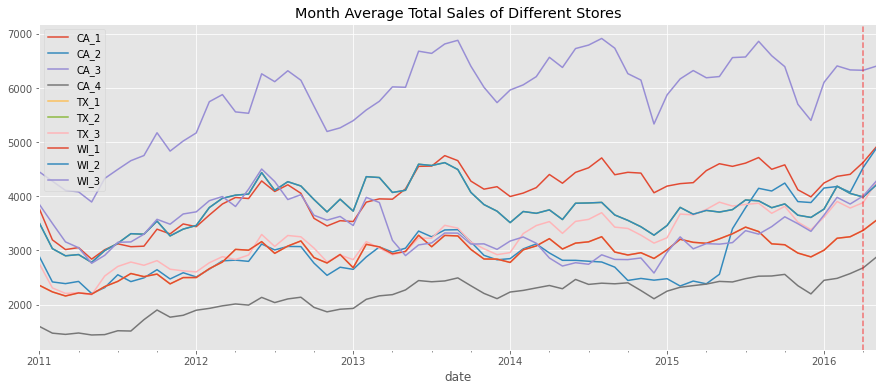

In [124]:
CA_1 = sales("store_id","CA_1")
CA_2 = sales("store_id","CA_2")
CA_3= sales("store_id","CA_3")
CA_4 = sales("store_id","CA_4")
monA_CA1 = CA_1['sales'].resample('MS').mean()
monA_CA2= CA_2['sales'].resample('MS').mean()
monA_CA3 = CA_3['sales'].resample('MS').mean()
monA_CA4 = CA_4['sales'].resample('MS').mean()
TX_1 = sales("store_id","TX_1")
TX_2 = sales("store_id","TX_2")
TX_3= sales("store_id","TX_3")
monA_TX1 = TX_1['sales'].resample('MS').mean()
monA_TX2= TX_2['sales'].resample('MS').mean()
monA_TX3 = TX_3['sales'].resample('MS').mean()
WI_1 = sales("store_id","WI_1")
WI_2 = sales("store_id","WI_2")
TX_3= sales("store_id","WI_3")
monA_WI1 = TX_1['sales'].resample('MS').mean()
monA_WI2= TX_2['sales'].resample('MS').mean()
monA_WI3 = TX_3['sales'].resample('MS').mean()
monA_CA1.plot(figsize=(15, 6))
monA_CA2.plot(figsize=(15, 6))
monA_CA3.plot(figsize=(15, 6))
monA_CA4.plot(figsize=(15, 6))
monA_TX1.plot(figsize=(15, 6))
monA_TX2.plot(figsize=(15, 6))
monA_TX3.plot(figsize=(15, 6))
monA_WI1.plot(figsize=(15, 6))
monA_WI2.plot(figsize=(15, 6))
monA_WI3.plot(figsize=(15, 6),title = ("Month Average Total Sales of Different Stores"))
plt.legend(store_list)
plt.ylabel = ("Sales")
plt.axvline(x=dt.datetime(2016,4,24), color='red', linestyle="dashed", alpha=0.5)
plt.show()

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

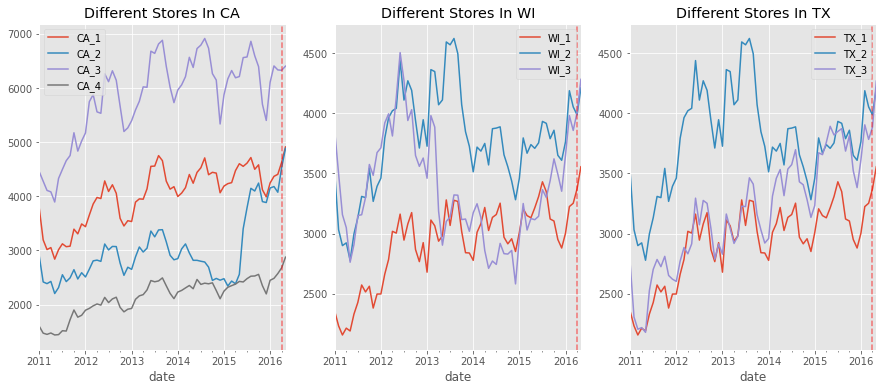

In [128]:
plt.subplot(1,3,1) # 一行三列,这是第一个图plt.subplot('行','列','编号')
CA_1 = sales("store_id","CA_1")
CA_2 = sales("store_id","CA_2")
CA_3= sales("store_id","CA_3")
CA_4 = sales("store_id","CA_4")
monA_CA1 = CA_1['sales'].resample('MS').mean()
monA_CA2= CA_2['sales'].resample('MS').mean()
monA_CA3 = CA_3['sales'].resample('MS').mean()
monA_CA4 = CA_4['sales'].resample('MS').mean()
monA_CA1.plot(figsize=(15, 6))
monA_CA2.plot(figsize=(15, 6))
monA_CA3.plot(figsize=(15, 6))
monA_CA4.plot(figsize=(15, 6),title = ("Different Stores In CA"))
plt.legend(store_list_ca)
plt.ylabel = ("Sales")
plt.axvline(x=dt.datetime(2016,4,24), color='red', linestyle="dashed", alpha=0.5)

plt.subplot(1,3,2) # 一行三列,这是第二个图
WI_1 = sales("store_id","WI_1")
WI_2 = sales("store_id","WI_2")
TX_3= sales("store_id","WI_3")
monA_WI1 = TX_1['sales'].resample('MS').mean()
monA_WI2= TX_2['sales'].resample('MS').mean()
monA_WI3 = TX_3['sales'].resample('MS').mean()
monA_WI1.plot(figsize=(15, 6))
monA_WI2.plot(figsize=(15, 6))
monA_WI3.plot(figsize=(15, 6),title = ("Different Stores In WI"))
plt.legend(store_list_wi)
plt.ylabel = ("Sales")
plt.axvline(x=dt.datetime(2016,4,24), color='red', linestyle="dashed", alpha=0.5)

plt.subplot(1,3,3) # 一行三列,这是第三个图
TX_1 = sales("store_id","TX_1")
TX_2 = sales("store_id","TX_2")
TX_3= sales("store_id","TX_3")
monA_TX1 = TX_1['sales'].resample('MS').mean()
monA_TX2= TX_2['sales'].resample('MS').mean()
monA_TX3 = TX_3['sales'].resample('MS').mean()
monA_TX1.plot(figsize=(15, 6))
monA_TX2.plot(figsize=(15, 6))
monA_TX3.plot(figsize=(15, 6),title = ("Different Stores In TX"))
plt.legend(store_list_tx)
plt.ylabel = ("Sales")
plt.axvline(x=dt.datetime(2016,4,24), color='red', linestyle="dashed", alpha=0.5)

plt.show()

### 4. Price

In [129]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000
6841117,WI_3,FOODS_3_827,11618,1.000000
6841118,WI_3,FOODS_3_827,11619,1.000000
6841119,WI_3,FOODS_3_827,11620,1.000000


In [130]:
sell_prices['Category'] = sell_prices['item_id'].str.split('_', expand=True)[0]
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,Category
0,CA_1,HOBBIES_1_001,11325,9.578125,HOBBIES
1,CA_1,HOBBIES_1_001,11326,9.578125,HOBBIES
2,CA_1,HOBBIES_1_001,11327,8.257812,HOBBIES
3,CA_1,HOBBIES_1_001,11328,8.257812,HOBBIES
4,CA_1,HOBBIES_1_001,11329,8.257812,HOBBIES


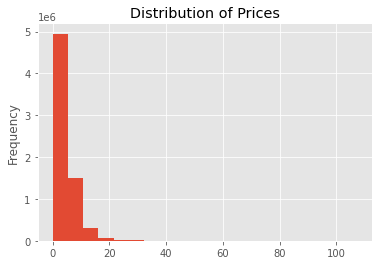

In [131]:
sell_prices['sell_price'].plot(kind='hist',bins=20,title='Distribution of Prices')
plt.set_xlabel = ('sell_price')
plt.show()

Text(0.5, 1.0, 'Boxplot of Sell Prices')

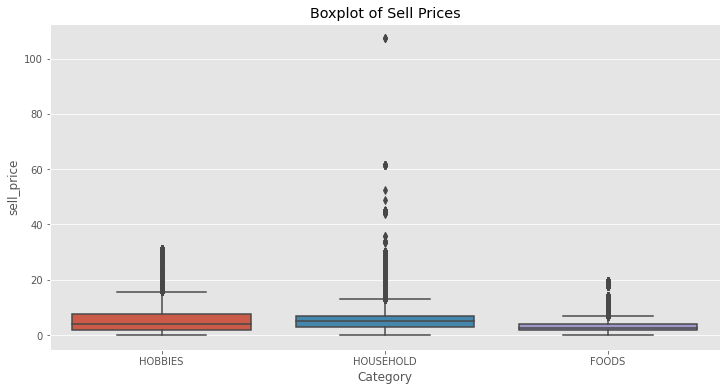

In [135]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sell_prices, x="Category", y='sell_price')
plt.title("Boxplot of Sell Prices")

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flex

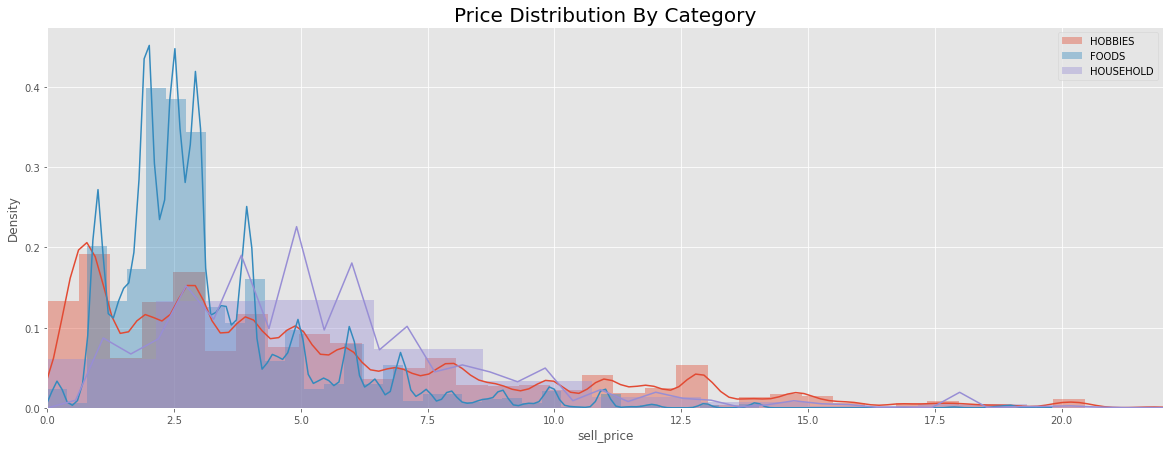

In [137]:
cat_price = sell_prices.groupby(["Category"])["sell_price"].sum()
plt.figure(figsize = (20,7))
plt.title('Price Distribution By Category', fontdict={'size':20})
plt.xlim(0,22)
sns.distplot(sell_prices.loc[sell_prices.item_id.str.contains('HOBBIES')].sell_price, label='HOBBIES')
sns.distplot(sell_prices.loc[sell_prices.item_id.str.contains('FOODS')].sell_price, label='FOODS')
sns.distplot(sell_prices.loc[sell_prices.item_id.str.contains('HOUSEHOLD')].sell_price, label='HOUSEHOLD')
plt.legend(loc = 'best')

### 5. Calendar

In [143]:
date_col = [col for col in train_sales if col.startswith('d_')]
#Setting the start date
base = dt.datetime(2011,1,29)
#Calculating the total sales in a day
sales_sum = pd.DataFrame(train_sales[date_col].sum(axis =0),columns = ["sales"])
#Adding the date column
sales_sum['datum'] = [base + dt.timedelta(days=x) for x in range(1941)]
sales_sum.set_index('datum', drop=True, inplace=True)
sales_sum.sort_index(inplace=True)

In [149]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [151]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
monthly_sales = sales_sum.groupby(sales_sum.index.strftime('%b')).mean().reindex(months)
monthly_sales.iplot(kind="bar",title = "Avgerage Sales across Months")

In [168]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [170]:
calendar_df.shape

(1969, 14)

In [172]:
# Event names for each event type
events1 = calendar_df[['event_type_1','event_name_1',]]
events2 = calendar_df[['event_type_2','event_name_2',]]
events2.columns = ["event_type_1","event_name_1"]
events = pd.concat([events1,events2],ignore_index = True)
events = events.dropna().drop_duplicates()
events
events_dict = {k: g["event_name_1"].tolist() for k,g in events.groupby("event_type_1")}
print("Event Names across different Event Types")
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in events_dict.items()]))
# 10 National and Religious events, 6 Cultural Events and 
# 3 Sporting events (30 events in total) in a year

Event Names across different Event Types


,Cultural,National,Religious,Sporting
0,ValentinesDay,PresidentsDay,LentStart,SuperBowl
1,StPatricksDay,MemorialDay,LentWeek2,NBAFinalsStart
2,Cinco De Mayo,IndependenceDay,Purim End,NBAFinalsEnd
3,Mother's day,LaborDay,OrthodoxEaster,NaN
4,Father's day,ColumbusDay,Pesach End,NaN
5,Halloween,VeteransDay,Ramadan starts,NaN
6,Easter,Thanksgiving,Eid al-Fitr,NaN
7,NaN,Christmas,EidAlAdha,NaN
8,NaN,NewYear,Chanukah End,NaN
9,NaN,MartinLutherKingDay,OrthodoxChristmas,NaN


In [174]:
# SNAP days for each month across the years for all the states.
snap_days = calendar_df.groupby(['year','month'])['snap_CA','snap_TX','snap_WI'].sum().reset_index()
print("SNAP days for each month across the years for all the states")
snap_days.pivot(index="month",columns = "year",values = ["snap_CA","snap_TX","snap_WI"])

SNAP days for each month across the years for all the states


/Users/zhujinghong/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



snap_CA                               snap_TX                          \
year     2011  2012  2013  2014  2015  2016    2011  2012  2013  2014  2015   
month                                                                         
1         0.0  10.0  10.0  10.0  10.0  10.0     0.0  10.0  10.0  10.0  10.0   
2        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
3        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
4        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
5        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
6        10.0  10.0  10.0  10.0  10.0  10.0    10.0  10.0  10.0  10.0  10.0   
7        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
8        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
9        10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
10       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
11       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   
12       10.0  10.0  10.0  10.0  10.0   NaN    10.0  10.0  10.0  10.0  10.0   

            snap_WI                                
year   2016    2011  2012  2013  2014  2015  2016  
month                                              
1      10.0     0.0  10.0  10.0  10.0  10.0  10.0  
2      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
3      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
4      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
5      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
6      10.0    10.0  10.0  10.0  10.0  10.0  10.0  
7       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
8       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
9       NaN    10.0  10.0  10.0  10.0  10.0   NaN  
10      NaN    10.0  10.0  10.0  10.0  10.0   NaN  
11      NaN    10.0  10.0  10.0  10.0  10.0   NaN  
12      NaN    10.0  10.0  10.0  10.0  10.0   NaN

In [177]:
#Joining the calender data with the sales data to see the impact of events
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
overall_sales_special = pd.merge(calendar_df,sales_sum, left_on = "date", right_on = "datum",how = "right")

In [ ]:
#  the unique days at which the 10 SNAP days of a month exists over the years

In [179]:
# CA
overall_sales_special.loc[overall_sales_special.snap_CA==1,"date"].dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [180]:
# TX
overall_sales_special.loc[overall_sales_special.snap_TX==1,"date"].dt.day.unique()

array([ 1,  3,  5,  6,  7,  9, 11, 12, 13, 15])

In [181]:
# WI
overall_sales_special.loc[overall_sales_special.snap_WI==1,"date"].dt.day.unique()

array([ 2,  3,  5,  6,  8,  9, 11, 12, 14, 15])

In [183]:
#  The daily sales for the year 2015. To see the pattern of impact of events¶
overall_sales_special[overall_sales_special.year == 2015].groupby("date")["sales"].sum().iplot(title = "Daily Overall Sales")

In [184]:
print("Event days in 2012")
overall_sales_special[(overall_sales_special.year == 2015) & ((overall_sales_special.event_name_1.notnull()) | (overall_sales_special.event_name_2.notnull()))]

Event days in 2012


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
1433,2015-01-01,11448,Thursday,6,1,2015,d_1434,NewYear,National,NaN,NaN,1,1,0,26452
1439,2015-01-07,11449,Wednesday,5,1,2015,d_1440,OrthodoxChristmas,Religious,NaN,NaN,1,1,0,29165
1451,2015-01-19,11451,Monday,3,1,2015,d_1452,MartinLutherKingDay,National,NaN,NaN,0,0,0,34412
1464,2015-02-01,11501,Sunday,2,2,2015,d_1465,SuperBowl,Sporting,NaN,NaN,1,1,0,40385
1477,2015-02-14,11503,Saturday,1,2,2015,d_1478,ValentinesDay,Cultural,NaN,NaN,0,0,1,41614
1479,2015-02-16,11503,Monday,3,2,2015,d_1480,PresidentsDay,National,NaN,NaN,0,0,0,37147
1481,2015-02-18,11503,Wednesday,5,2,2015,d_1482,LentStart,Religious,NaN,NaN,0,0,0,28505
1488,2015-02-25,11504,Wednesday,5,2,2015,d_1489,LentWeek2,Religious,NaN,NaN,0,0,0,29227
1496,2015-03-05,11505,Thursday,6,3,2015,d_1497,Purim End,Religious,NaN,NaN,1,1,1,32819
1508,2015-03-17,11507,Tuesday,4,3,2015,d_1509,StPatricksDay,Cultural,NaN,NaN,0,0,0,31412


In [186]:
#Function for tagging events to the preceding weekend 
event_days_sales = overall_sales_special[((overall_sales_special.event_name_1.notnull()) | (overall_sales_special.event_name_2.notnull()))]
overall_sales_special["weekend_precede_event"] = np.nan

def update_weekend_precede_event(week_e,wday,e1,e2):
    e2 = '_' + e2 if type(e2) == str else ''
    drift = e1 + e2
    if wday == 1:
        overall_sales_special.loc[(overall_sales_special['wm_yr_wk']==week_e)&(overall_sales_special['wday']==1),"weekend_precede_event"] = drift
    else:
        overall_sales_special.loc[(overall_sales_special['wm_yr_wk']==week_e)&((overall_sales_special['wday']==1)|(overall_sales_special['wday']==2)),"weekend_precede_event"] = drift
        
_ = event_days_sales.apply(lambda row : update_weekend_precede_event(row['wm_yr_wk'],row['wday'],row['event_name_1'], row['event_name_2']),axis = 1)

In [187]:
#adding event type column
events.columns = ["weekend_precede_event_type","weekend_precede_event"]
overall_sales_special = pd.merge(overall_sales_special,events,how= "left",on="weekend_precede_event")

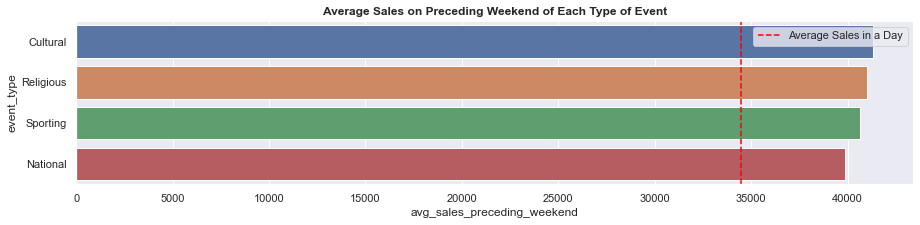

In [209]:
#Calculating sales impact of each event on preceding weekend
event_type_impact = overall_sales_special.groupby(['weekend_precede_event_type'])['sales'].mean().reset_index()
event_type_impact = event_type_impact.sort_values("sales",ascending = False)
event_type_impact.columns = ["event_type","avg_sales_preceding_weekend"]
#Plotting a bar graph of avg. sales on the weekend days before the event to see the impact
chart = sns.barplot(y= "event_type", x='avg_sales_preceding_weekend', data=event_type_impact)
chart.axvline(sales_sum.sales.mean(),label = "Average Sales in a Day",c='red', linestyle='dashed')
plt.title("Average Sales on Preceding Weekend of Each Type of Event", fontweight ="bold")
leg = plt.legend()

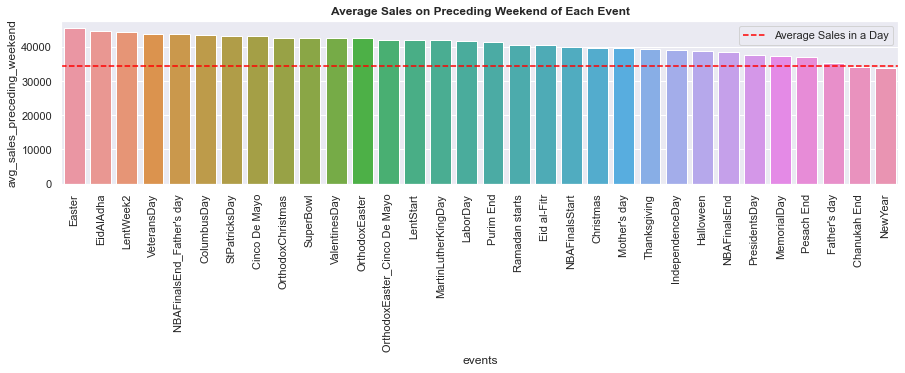

In [210]:
#Calculating sales impact of each event on preceding weekend
event_impact = overall_sales_special.groupby(['weekend_precede_event'])['sales'].mean().reset_index()
event_impact = event_impact.sort_values("sales",ascending = False)
event_impact.columns = ["events","avg_sales_preceding_weekend"]
# Plotting a bar graph of avg. sales on the weekend days before the event to see the impact
sns.set(rc={'figure.figsize':(15,3)})
chart = sns.barplot(x= "events", y='avg_sales_preceding_weekend', data=event_impact)
chart.axhline(sales_sum.sales.mean(),label = "Average Sales in a Day",c='red', linestyle='dashed')
var = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title("Average Sales on Preceding Weekend of Each Event",fontweight = "bold")
leg = plt.legend()